<a href="https://colab.research.google.com/github/daemonX10/Generative-Deep-Learning/blob/main/01_Auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers ,models,datasets,callbacks
import tensorflow.keras.backend as K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
IMAGE_SIZE=32
CHANNELS =1
BATCH_SIZE=100
BUFFER_SIZE = 1000
VALIDATION_SPLIT=0.2
EMBEDDING_DIM =2
EPOCHS =3


In [ ]:

# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

def preprocess(imgs):
    imgs =imgs.astype("float32")/255.0
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

x_train =preprocess(x_train)
x_test= preprocess(x_test)

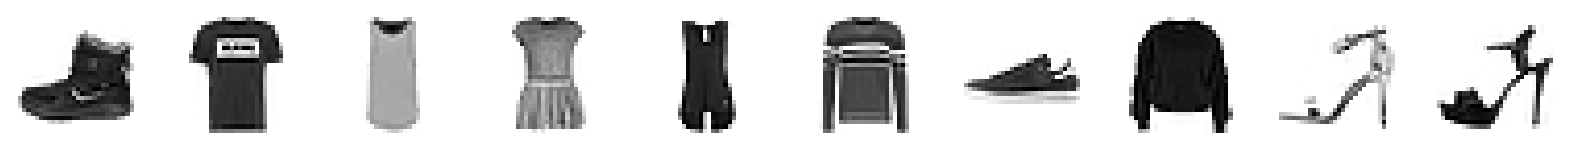

In [ ]:
display(x_train)

In [ ]:
encoder_input =layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name='encoder_input')

x =layers.Conv2D(32,(3,3),strides=2,activation='relu',padding='same')(encoder_input)
x=layers.Conv2D(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2D(128,(3,3),strides=2,activation='relu',padding='same')(x)
shape_before_flattening=K.int_shape(x)[1:]

x=layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM,name='encoder_output')(x)

encoder = models.Model(encoder_input,encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_input = layers.Input(shape=(2,),name='decoder_input')
x=layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x=layers.Reshape(shape_before_flattening)(x)
x=layers.Conv2DTranspose(128,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(x)

decoder_output=layers.Conv2D(1,(3,3),strides=1,activation='sigmoid',padding='same',name='decoder_output')(x)

decoder = models.Model(decoder_input,decoder_output)

In [ ]:
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder = models.Model(encoder_input,decoder(encoder_output))

In [ ]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./kaggle/checkpoint.keras',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0,
)

tensorboard_callback =callbacks.TensorBoard(log_dir='./kaggle/loss.keras')

In [ ]:
autoencoder.fit(
  x_train,
  x_train,
  epochs=EPOCHS,
  batch_size = BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test,x_test),
    callbacks=[model_checkpoint_callback,tensorboard_callback]
)

Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 105s 169ms/step - loss: 0.3506 - val_loss: 0.2597
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 102s 170ms/step - loss: 0.2577 - val_loss: 0.2565
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 100s 167ms/step - loss: 0.2539 - val_loss: 0.2542


In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs("./kaggle/models", exist_ok=True)


In [ ]:
# Save the final models
autoencoder.save("./kaggle/models/autoencoder.keras")  # Use .keras extension
encoder.save("./kaggle/models/encoder.keras")
decoder.save("./kaggle/models/decoder.keras")

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
example real clothing items


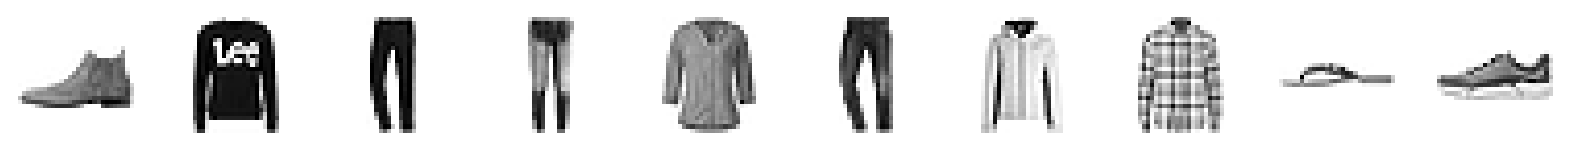

reconstruction


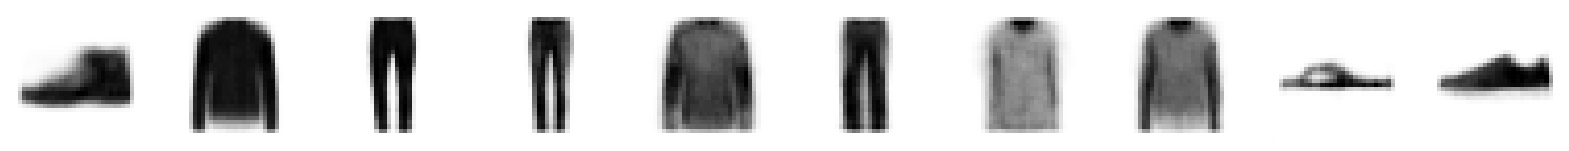

In [ ]:
predications = autoencoder.predict(example_images)
print("example real clothing items")
display(example_images)
print('reconstruction')
display(predications)

In [ ]:
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
print(embeddings[:10])


[[-1.3552945   1.3279182 ]
 [-3.392952   -3.982211  ]
 [ 3.7283323  -4.0804768 ]
 [ 2.6150658  -2.2903514 ]
 [-2.2148066  -1.7160658 ]
 [ 2.0319073  -3.3679342 ]
 [-0.55715674 -1.637553  ]
 [-1.4472814  -1.8539971 ]
 [ 0.31390807  1.8359026 ]
 [-0.9176521   2.6025882 ]]


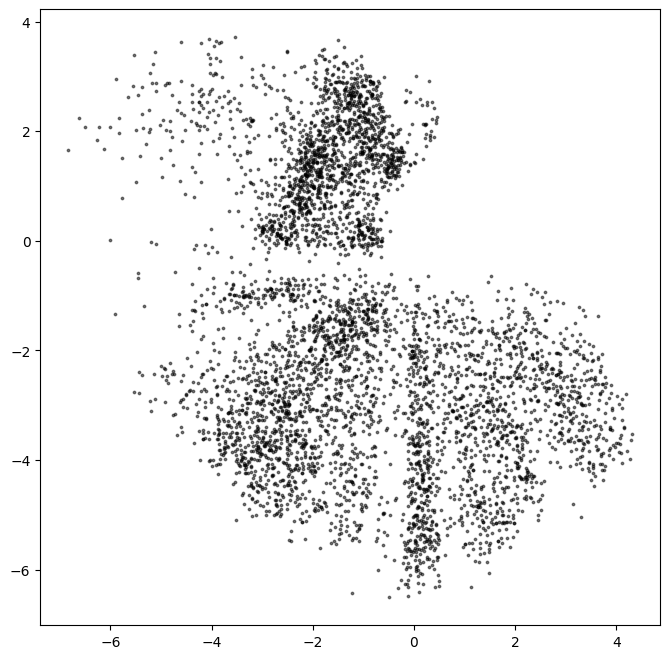

In [ ]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

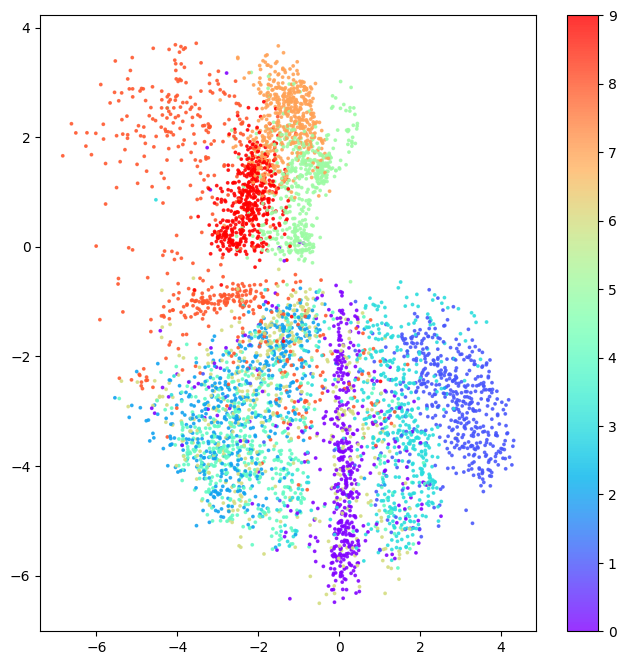

In [ ]:

# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [ ]:

# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)